In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools

!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null

!apt-get update -qq 2>&1 > /dev/null

!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth

auth.authenticate_user()


from oauth2client.client import GoogleCredentials

creds = GoogleCredentials.get_application_default()

import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL

vcode = getpass.getpass()

!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


!mkdir -p drive

!google-drive-ocamlfuse drive

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········


In [0]:
# !ls drive/ColabNotebooks/

In [0]:
import numpy as np
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

In [0]:
def initialize_parameters(n_input, n_hidden): # initialize parameters with tiny random numbers
    num_of_layers = len(n_hidden)
    parameters = {}
    
    parameters['w1'] = np.random.randn(n_hidden[0], n_input) * np.sqrt(2/n_input)
    parameters['b1'] = np.zeros((n_hidden[0], 1))
    
    for i in range(1, num_of_layers):
        parameters['w'+str(i+1)] = np.random.randn(n_hidden[i], n_hidden[i-1]) * np.sqrt(2/n_hidden[i-1])
        parameters['b'+str(i+1)] = np.zeros((n_hidden[i], 1))
    
    parameters['w'+str(num_of_layers+1)] = np.random.randn(1, n_hidden[num_of_layers-1]) * np.sqrt(2/n_hidden[num_of_layers-1])
    parameters['b'+str(num_of_layers+1)] = np.zeros((1, 1))

    return parameters

In [0]:
def relu(z):
    return np.maximum(z, 0)

def relu_derivative(z):
    der = np.zeros(z.shape)
    der[z >= 0] = 1
    return der

In [0]:
def forward_prop(x, parameters, activation, keep_prob=1.0):
    cache = {}
    last_layer = len(parameters) // 2
    cache['a'+str(0)] = x
    
    for l in range(1, last_layer+1):
        cache['z'+str(l)] = np.dot(parameters['w'+str(l)], cache['a'+str(l-1)]) + parameters['b'+str(l)]
        if l == last_layer: 
            cache['a'+str(last_layer)] = 1/(1 + np.exp(-cache['z'+str(last_layer)]))
        elif activation == 'relu':
            cache['a'+str(l)] = relu(cache['z'+str(l)])
        elif activation == 'sigmoid': 
            cache['a'+str(l)] = 1/(1 + np.exp(-cache['z'+str(l)]))
        elif activation == 'tanh': 
            cache['a'+str(l)] = np.tanh(cache['z'+str(l)])
        
        if keep_prob != 1.0 and l != last_layer:
            dropout_temp = np.random.randn(cache['a'+str(l)].shape[0], cache['a'+str(l)].shape[1]) < keep_prob
            cache['dropout_vec'+str(l)] = dropout_temp 
            cache['a'+str(l)] = np.multiply(cache['a'+str(l)], dropout_temp) / keep_prob

    return cache

In [0]:
def back_prop(x, y, cache, parameters, activation, _lambda, keep_prob):
    m = x.shape[1]
    gradients = {}
    last_layer = len(parameters) // 2

    gradients['dz'+str(last_layer)] = cache['a'+str(last_layer)] - y.T
    gradients['dw'+str(last_layer)] = 1/m * np.dot(gradients['dz'+str(last_layer)], cache['a'+str(last_layer-1)].T) + _lambda/m * parameters['w'+str(last_layer)]
    gradients['db'+str(last_layer)] = 1/m * np.sum(gradients['dz'+str(last_layer)], axis=1, keepdims=True)
        
    for i in reversed(range(1, last_layer)):
        dA = np.dot(parameters['w'+str(i+1)].T, gradients['dz'+str(i+1)])
        if keep_prob != 1.0 and i != last_layer:
            dA *= cache['dropout_vec'+str(i)]
            dA /= keep_prob
            
        if activation == 'sigmoid': 
            sigmoid = 1/(1 + np.exp(-cache['z'+str(i)]))
            gradients['dz'+str(i)] = dA * (sigmoid * (1 - sigmoid))
        elif activation == 'relu':
            gradients['dz'+str(i)] = dA * relu_derivative(cache['z'+str(i)])
        elif activation == 'tanh': 
            gradients['dz'+str(i)] = dA * (1 - np.power(np.tanh(cache['z'+str(i)]), 2))
     
        gradients['dw'+str(i)] = 1/m * np.dot(gradients['dz'+str(i)], cache['a'+str(i-1)].T) + _lambda/m * parameters['w'+str(i)]
        gradients['db'+str(i)] = 1/m * np.sum(gradients['dz'+str(i)], axis=1, keepdims=True)
    
    return gradients

In [0]:
def cost_function(m, labels, y_hat, params, lambd): # regularized
    last_layer = len(params) // 2
    return -1/m * (np.sum(labels * np.log(y_hat)) + np.sum((1-labels) * np.log(1 - y_hat))) + lambd/(2*m) * np.sum([
            np.power(np.linalg.norm(params['w'+str(i)]), 2) for i in range(1, last_layer+1)])

In [0]:
def save_weights(parameters):
    for i in range(1, (len(parameters)//2)+1):
        np.save("w"+str(i), parameters['w'+str(i)])
        np.save("b"+str(i), parameters['b'+str(i)])

In [0]:
def load_weights(num):
    parameters = {}
    for i in range(1, num+1):
        parameters["w"+str(i)] = np.load("w"+str(i)+".npy")
        parameters["b"+str(i)] = np.load("b"+str(i)+".npy")

In [0]:
def multi_Layer_NN(samples, labels, n_hidden, num_iterations, batch_size=None, load_last_weights=0, activation="tanh", learning_rate=0.01, _lambda=0, keep_prob_dropout=1.0, print_cost=False):
    m = samples.shape[1]
    if not batch_size:
       batch_size = m
    
    if load_last_weights == 0:
       params = initialize_parameters(samples.shape[0], n_hidden)
    else:
       params = load_weights(load_last_weights)       
    
    cost_history = []
    last_layer = len(params) // 2
    
    for i in range(1, num_iterations+1):
        cost = []
        
        for t in range(int(m/batch_size)):
            
            cache = forward_prop(samples[:, int(t*batch_size):int((t+1)*batch_size)], params, activation, keep_prob_dropout)
            
            gradients = back_prop(samples[:, int(t*batch_size):int((t+1)*batch_size)],
                                  labels[int(t*batch_size):int((t+1)*batch_size)], 
                                  cache, 
                                  params, 
                                  activation, 
                                  _lambda, 
                                  keep_prob_dropout)
            
            for j in range(1, last_layer+1):
                params['w'+str(j)] -= learning_rate * gradients['dw'+str(j)]
                params['b'+str(j)] -= learning_rate * gradients['db'+str(j)]

            cost.append(cost_function(int(batch_size), labels[int(t*batch_size):int((t+1)*batch_size)], cache['a'+str(last_layer)].T, params, _lambda))   
             
        if print_cost: 
#             cost = cost_function(m, labels, cache['a'+str(last_layer)].T, params, _lambda)
            print('cost after epoch {}: {}'.format(int(i), np.sum(cost)))
            cost_history.append(np.sum(cost))
              
    return {'parameters':params, 
            'cache': cache,
            'cost_history':cost_history
           }


In [0]:
def predict(x, parameters, activation):
    last_layer = len(parameters) // 2
    cache = forward_prop(x.T, parameters, activation)
    y_hat = cache['a'+str(last_layer)]
    y_hat[y_hat >= 0.5] = 1
    y_hat[y_hat < 0.5] = 0

    return y_hat.T

## load dataset section

In [0]:
import scipy.io
samples = scipy.io.loadmat('drive/ColabNotebooks/olivettifaces.mat')
samples = samples['faces'].T
labels = np.ones((samples.shape[0], 1))
artificialZeroData = np.random.randint(0, 256, (samples.shape[0], samples.shape[1]))
artificialZeroLabel = np.zeros((artificialZeroData.shape[0], 1))
samples = np.vstack((samples, artificialZeroData))
labels = np.vstack((labels, artificialZeroLabel))

_mean = np.mean(samples, axis=1).reshape(-1, 1)
variance = (np.std(samples, axis=1)**2).reshape(-1, 1)
samples = (samples - _mean)/variance

samples_sparse = coo_matrix(samples)
samples, samples_sparse, labels = shuffle(samples, samples_sparse, labels)

train_data, test_data, train_label, test_label = train_test_split(samples, labels, test_size=0.30, random_state=4)

In [14]:
print(samples.shape, labels.shape)

(800, 4096) (800, 1)


## train section

In [31]:
import time

tic = time.time()
activation_function = 'relu'
model = multi_Layer_NN(train_data.T,
                         train_label,
                         activation=activation_function,
                         n_hidden=[100, 100, 100],
                         num_iterations=500,
                         batch_size=56,
                         learning_rate=0.1,
                         _lambda = 0.01,
                         keep_prob_dropout= .7,
                         print_cost=True)

print("Train phase time:", time.time()-tic)

cost after epoch 1: 7.307424250916565
cost after epoch 2: 6.355181451487798
cost after epoch 3: 4.676904781211211
cost after epoch 4: 2.888257715749046
cost after epoch 5: 1.8268688098584418
cost after epoch 6: 1.3179262320777785
cost after epoch 7: 1.032378978139278
cost after epoch 8: 0.9461976388768101
cost after epoch 9: 0.8572668043480234
cost after epoch 10: 0.8026568636469187
cost after epoch 11: 0.7439905831904164
cost after epoch 12: 0.7031325212563697
cost after epoch 13: 0.6985992889166801
cost after epoch 14: 0.6784030998375057
cost after epoch 15: 0.6506198346578004
cost after epoch 16: 0.6531900918190083
cost after epoch 17: 0.6255250905919109
cost after epoch 18: 0.6606274824656573
cost after epoch 19: 0.6174683710928954
cost after epoch 20: 0.6038332825612724
cost after epoch 21: 0.6192084974938673
cost after epoch 22: 0.597322977503977
cost after epoch 23: 0.5980060298421618
cost after epoch 24: 0.6082944288558184
cost after epoch 25: 0.6176248455610657
cost after epoc

cost after epoch 101: 0.5436841046049384
cost after epoch 102: 0.5470266826408255
cost after epoch 103: 0.5387455232548383
cost after epoch 104: 0.5427207605481117
cost after epoch 105: 0.536729922702664
cost after epoch 106: 0.5421210323204698
cost after epoch 107: 0.5405686497852882
cost after epoch 108: 0.5371217870438162
cost after epoch 109: 0.5380984757800122
cost after epoch 110: 0.5410860438487379
cost after epoch 111: 0.5375680171372078
cost after epoch 112: 0.5375355994508193
cost after epoch 113: 0.5373883078926536
cost after epoch 114: 0.5356253120271299
cost after epoch 115: 0.5358405706992668
cost after epoch 116: 0.5382262493342036
cost after epoch 117: 0.5441485219811201
cost after epoch 118: 0.5348524804027467
cost after epoch 119: 0.5440526589161978
cost after epoch 120: 0.5362474275351319
cost after epoch 121: 0.5345842468755208
cost after epoch 122: 0.5354162519650348
cost after epoch 123: 0.5342796574728991
cost after epoch 124: 0.5337034216297843
cost after epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


cost after epoch 144: nan
cost after epoch 145: 0.5301598797136158
cost after epoch 146: 0.5361264674837708
cost after epoch 147: 0.5386773298248043
cost after epoch 148: 0.5374719015444882
cost after epoch 149: 0.5309864700770889
cost after epoch 150: 0.5278984683400769
cost after epoch 151: 0.5282081809266597
cost after epoch 152: nan
cost after epoch 153: 0.528980664639933
cost after epoch 154: 0.5283728104175149
cost after epoch 155: 0.5331261793074238
cost after epoch 156: 0.5277864661853451
cost after epoch 157: 0.526792892468901
cost after epoch 158: 0.5275028784962145
cost after epoch 159: 0.5305525198347394
cost after epoch 160: 0.5280462376530002
cost after epoch 161: 0.5269104254495263
cost after epoch 162: 0.5277264429967213
cost after epoch 163: 0.5259030669677012
cost after epoch 164: 0.5289664232557049
cost after epoch 165: 0.543649406893338
cost after epoch 166: 0.5261906715804071
cost after epoch 167: 0.5258807802158959
cost after epoch 168: 0.5259515174450462
cost aft

cost after epoch 259: 0.5079887510024115
cost after epoch 260: 0.5090021172670195
cost after epoch 261: 0.5082302788761718
cost after epoch 262: 0.5075693241675442
cost after epoch 263: nan
cost after epoch 264: 0.507911572595619
cost after epoch 265: 0.5139100435576092
cost after epoch 266: 0.5064942612990279
cost after epoch 267: 0.506348465767306
cost after epoch 268: 0.5064719998785291
cost after epoch 269: nan
cost after epoch 270: nan
cost after epoch 271: 0.507196373787297
cost after epoch 272: 0.5058626817903275
cost after epoch 273: 0.5070474783602216
cost after epoch 274: 0.5060415632111009
cost after epoch 275: 0.5056372951390983
cost after epoch 276: 0.5049761078026829
cost after epoch 277: nan
cost after epoch 278: 0.510282739856464
cost after epoch 279: 0.5039365082639207
cost after epoch 280: 0.504417980035821
cost after epoch 281: 0.5046735056661515
cost after epoch 282: 0.5041340378526407
cost after epoch 283: 0.5051459755083973
cost after epoch 284: 0.5031099815831263

cost after epoch 378: 0.4882222336600047
cost after epoch 379: 0.4872355939621533
cost after epoch 380: 0.4873751339706383
cost after epoch 381: 0.48740924983441514
cost after epoch 382: nan
cost after epoch 383: 0.4863378804774282
cost after epoch 384: 0.48755996095702403
cost after epoch 385: 0.4861576137026406
cost after epoch 386: nan
cost after epoch 387: 0.4868668577356061
cost after epoch 388: 0.48621235135338414
cost after epoch 389: 0.4899314484100218
cost after epoch 390: 0.4907270497047098
cost after epoch 391: 0.48544351443201483
cost after epoch 392: nan
cost after epoch 393: 0.4847989727868435
cost after epoch 394: 0.48543737606085746
cost after epoch 395: 0.48446257911992846
cost after epoch 396: 0.4857008088591662
cost after epoch 397: 0.48399910436876975
cost after epoch 398: 0.48419092512658624
cost after epoch 399: 0.4881356143425998
cost after epoch 400: 0.4837479462081826
cost after epoch 401: 0.4829776118765255
cost after epoch 402: 0.4831840478140579
cost after e


cost after epoch 496: 0.4716404256857815
cost after epoch 497: 0.4676383636835725
cost after epoch 498: 0.46729730690177634
cost after epoch 499: 0.468766846416099
cost after epoch 500: 0.4685587034590217
Train phase time: 50.15855622291565


In [32]:
pred_labels = predict(train_data, parameters=model['parameters'], activation=activation_function)
print('accuracy on train set:', (np.sum(pred_labels == train_label)/pred_labels.size) * 100, '%')
pred_labels = predict(test_data, parameters=model['parameters'], activation=activation_function)
print('accuracy on test set:', (np.sum(pred_labels == test_label)/pred_labels.size) * 100, '%')

accuracy on train set: 100.0 %
accuracy on test set: 100.0 %


### plot cost value

In [0]:
plt.plot(range(len(model['cost_history'])), model['cost_history'])
plt.show()

### test an example of test set

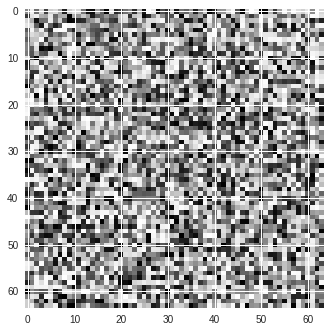

[[0.]]
Not-Human


In [46]:
photo_number = 15
imgplot = plt.imshow(test_data[photo_number].reshape(64, 64))
plt.show()
pred_labels = predict(test_data[photo_number].reshape(1, -1), parameters=model['parameters'], activation=activation_function)
print(pred_labels)
if int(pred_labels[0][0]) == 1:
    print('Human')
else:
    print('Not-Human')

### predict an example from you
It must be a 64*64 photo.

In [0]:
# myimg = mpimg.imread('myimg.jpg')
# imgplot = plt.imshow(myimg)
# print(myimg.shape)

def predict_new_photo(photo_name):
    # import photo and convert it to greyscale 64*64
    x=Image.open(photo_name, 'r')
    x=x.convert('L') #makes it greyscale
    y=np.asarray(x.getdata(), dtype=np.float64).reshape((x.size[1],x.size[0]))
    y=np.asarray(y, dtype=np.uint8) #if values still in range 0-255! 
    w=Image.fromarray(y,mode='L')
    w.save('out.jpg')

    # rotate imgae 90 degree
    raw_img = Image.open("out.jpg")
    img = raw_img.rotate(90)
    # img.show()
    img.save("out.jpg")

    myimg = mpimg.imread('out.jpg')
    imgplot = plt.imshow(myimg)

    pred_labels = predict(myimg.reshape(1, -1), parameters=model['parameters'], activation=activation_function)
    if int(pred_labels[0][0]) == 1:
        print('Human')
    else:
        print('Not-Human')

In [0]:
m = 6
plt.subplot(m,1, 1)
predict_new_photo('drive/ColabNotebooks/myimg.jpg')
plt.subplot(m,1, 2)
predict_new_photo('drive/ColabNotebooks/myimg2.jpg')
plt.subplot(m,1, 3)
predict_new_photo('drive/ColabNotebooks/myimg3.jpg')
plt.subplot(m,1, 4)
predict_new_photo('drive/ColabNotebooks/myimg4.jpg')
plt.subplot(m,1, 5)
predict_new_photo('drive/ColabNotebooks/myimg6.jpg')
plt.subplot(m,1, 6)
predict_new_photo('drive/ColabNotebooks/myimg5.jpg')

### run a package with the same parameters to check it

In [0]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(200, 500, 200), activation='tanh', solver='sgd', alpha=0, learning_rate_init=0.1, max_iter=10000)
clf.fit(train_data, train_label)

print('accuracy on train set:', clf.score(train_data, train_label)*100)
print('accuracy on test set:', clf.score(test_data, test_label)*100)
print('loss:', clf.loss_)

In [0]:
myimg = mpimg.imread('out.jpg')
print(clf.predict(myimg.reshape(1, -1)))